In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# To make experiments reproducible
import keras
keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
print(tf.__version__) # print TF version
tf.keras.backend.clear_session()  # For easy reset of notebook state

In [ ]:
def init():
  """
  This function produces:

  The normal (original) Fashion MNIST training and test feature data (x_test and x_train)
  The noisy Fashion MNIST training and test data (x_test_noisy and x_train_noisy)
  """

  (x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

  # Normalize train and test data
  x_train = x_train.astype('float32') / 255.0
  x_test = x_test.astype('float32') / 255.0


  # Reshape so that each instance is a linear array of 784 normalized pixel values
  x_train = x_train.reshape((len(x_train), 784))
  x_test = x_test.reshape((len(x_test), 784))

  print ("Shape of training feature data is ", x_train.shape)
  print ("Shape of testing feature data is ", x_test.shape)

  # Add random noise to the image
  noise_factor = 0.2
  x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
  x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

  # Clip the resulting values so that they don't fall outside values of 0 and 1
  x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
  x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

  print (x_train.shape, x_test.shape)
  print (x_train_noisy.shape, x_test_noisy.shape)

  return(x_train, x_test, x_train_noisy, x_test_noisy)

In [ ]:
def visualization(x_original, x_noisy, x_reconstructed):
  """
  Description here
  """

  # Plot Original
  pixels_original = x_original.reshape((28, 28))
  plt.subplot(1, 3, 1)
  plt.title("Original")
  plt.imshow(np.clip(pixels_original + 0.5, 0, 1,), cmap='gray')

  # Plot Noisy
  pixels_noisy = x_noisy.numpy().reshape((28, 28))
  plt.subplot(1, 3, 2)
  plt.title("Noisy")
  plt.imshow(np.clip(pixels_noisy + 0.5, 0, 1,), cmap='gray')

  # Plot Reconstructed
  pixels_original = x_reconstructed.reshape((28, 28))
  plt.subplot(1, 3, 3)
  plt.title("Reconstructed")
  plt.imshow(np.clip(pixels_original + 0.5, 0, 1,), cmap='gray')
  plt.show()

In [ ]:
class AutoEncoder(keras.Model):
  
  def __init__(self, name=None):
    super(AutoEncoder, self).__init__(name=name)
    
    # Initialize Matrices of weights for each layer of neurons
    self.initializer = keras.initializers.he_normal()

    #  Matrices = (number of neurons, number of features)
    self.w_1 = tf.Variable(self.initializer(shape=(128, 784))) # First layer receives all features input size=784
    self.w_2 = tf.Variable(self.initializer(shape=(64, 128)))
    self.w_3 = tf.Variable(self.initializer(shape=(32, 64)))
    self.w_4 = tf.Variable(self.initializer(shape=(64, 32)))
    self.w_5 = tf.Variable(self.initializer(shape=(128, 64)))
    self.w_6 = tf.Variable(self.initializer(shape=(784, 128))) # Last layer outputs a Matrix with all features (hopefully well reconstructed) output size=784

    
  def mean_absolute_error(self, y_true, y_pred):
    """
    This function receives two matrix data points 'y_pred' and 'y_true' , which are the predictions from the AE and the original image.
    Then the loss is calculated utilizing the MAE formula.
    """
    return tf.reduce_mean(tf.abs(y_true - y_pred))

  def sigmoid(self, inputs):
    """
    Description here
    """
    exp_x = tf.math.exp(inputs)
    output =  tf.math.divide(exp_x,(1 + exp_x))
    return(output)

  def call(self, inputs):
      a_1 = tf.matmul(inputs, self.w_1, transpose_a=False, transpose_b=True)
      h_1 = tf.keras.activations.relu(a_1)

      a_2 = tf.matmul(h_1, self.w_2, transpose_a=False, transpose_b=True)
      h_2 = tf.keras.activations.relu(a_2)

      a_3 = tf.matmul(h_2, self.w_3, transpose_a=False, transpose_b=True)
      h_3 = tf.keras.activations.relu(a_3)

      a_4 = tf.matmul(h_3, self.w_4, transpose_a=False, transpose_b=True)
      h_4 = tf.keras.activations.relu(a_4)

      a_5 = tf.matmul(h_4, self.w_5, transpose_a=False, transpose_b=True)
      h_5 = tf.keras.activations.relu(a_5)

      a_6 = tf.matmul(h_5, self.w_6, transpose_a=False, transpose_b=True)
      y_pred = self.sigmoid(a_6)

      return(y_pred)

  def forward_pass(self, X_batch, y_batch, optimizer):
    """
    This function takes an 'X_batch' matrix data points from the training set that will be pushed through the dense AE.
    Once the prediction is done by the AE, the Loss is calculate between 'y_pred' and 'y_batch'.
    Following the gradient is computed and the weights are update using the Adam's Optimizer
    """
    
    with tf.GradientTape() as tape:
      # Push the data through the layer of neurons
      # and compute the weights of each layer
      #################### Layers of Neurons ##########################
      a_1 = tf.matmul(X_batch, self.w_1, transpose_a=False, transpose_b=True)
      h_1 = tf.keras.activations.relu(a_1)

      a_2 = tf.matmul(h_1, self.w_2, transpose_a=False, transpose_b=True)
      h_2 = tf.keras.activations.relu(a_2)

      a_3 = tf.matmul(h_2, self.w_3, transpose_a=False, transpose_b=True)
      h_3 = tf.keras.activations.relu(a_3)

      a_4 = tf.matmul(h_3, self.w_4, transpose_a=False, transpose_b=True)
      h_4 = tf.keras.activations.relu(a_4)

      a_5 = tf.matmul(h_4, self.w_5, transpose_a=False, transpose_b=True)
      h_5 = tf.keras.activations.relu(a_5)

      a_6 = tf.matmul(h_5, self.w_6, transpose_a=False, transpose_b=True)
      y_pred = self.sigmoid(a_6)
      #################### End of Layers of Neurons ###################

      loss = self.mean_absolute_error(y_batch, y_pred)

    # Calculate gradients with respect to every trainable variable
    grads = tape.gradient(loss, [self.w_1, self.w_2, self.w_3, self.w_4, self.w_5, self.w_6])
      
    # Update weights using the gradient
    optimizer.apply_gradients(zip(grads, [self.w_1, self.w_2, self.w_3, self.w_4, self.w_5, self.w_6]))

    return(loss)

def get_model():
  return AutoEncoder(name='autoencoder')


### START

In [7]:
#################### Initialization of variables ##########################
x_train, x_test, x_train_noisy, x_test_noisy = init()
learning_rate = 0.001
epochs = 200
batch_size = 50
loss_history = [] # List for save loss across the epochs
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # Define the optimizer with the sepcific learning rate
#################### End of Initialization of variables ###################

model = get_model()

for epoch in range(epochs):
  # Run for all epochs
  for step in range(x_train_noisy.shape[0]//batch_size):
    # Run batches within an epoch
    s_index = batch_size * step
    e_index = batch_size * (step + 1)

    X_batch = x_train_noisy[s_index:e_index]
    y_batch = x_train[s_index:e_index]

    loss = model.forward_pass(X_batch, y_batch, optimizer)
  
  loss_history.append(loss) # Save the loss for each epoch  
  print(f'Epoch: {epoch+1} Training loss: {loss}')
    



Epoch: 1 Training loss: 0.07933790236711502
Epoch: 2 Training loss: 0.07095962017774582
Epoch: 3 Training loss: 0.0666559711098671
Epoch: 4 Training loss: 0.0641302764415741
Epoch: 5 Training loss: 0.06635408103466034
Epoch: 6 Training loss: 0.0627053901553154
Epoch: 7 Training loss: 0.06178276240825653
Epoch: 8 Training loss: 0.05914489924907684
Epoch: 9 Training loss: 0.05815774202346802
Epoch: 10 Training loss: 0.061441127210855484
Epoch: 11 Training loss: 0.058572910726070404
Epoch: 12 Training loss: 0.05728795751929283
Epoch: 13 Training loss: 0.05673994496464729
Epoch: 14 Training loss: 0.055476024746894836
Epoch: 15 Training loss: 0.05510496720671654
Epoch: 16 Training loss: 0.05542893335223198
Epoch: 17 Training loss: 0.05495874583721161
Epoch: 18 Training loss: 0.054466404020786285
Epoch: 19 Training loss: 0.05457206442952156
Epoch: 20 Training loss: 0.05433545261621475
Epoch: 21 Training loss: 0.053884364664554596
Epoch: 22 Training loss: 0.05402625724673271
Epoch: 23 Trainin

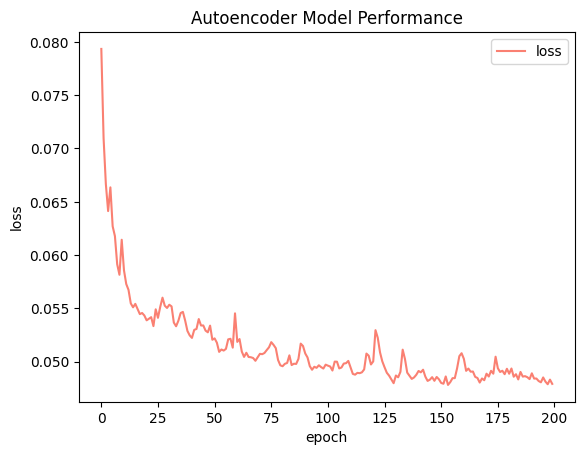

In [8]:
# History for loss
plt.plot(loss_history, label="loss", color='salmon')
plt.legend()
plt.title('Autoencoder Model Performance')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Predictions

In [9]:
predictions = model.predict(x_test_noisy)
print("predictions shape:", predictions.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
predictions shape: (10000, 784)


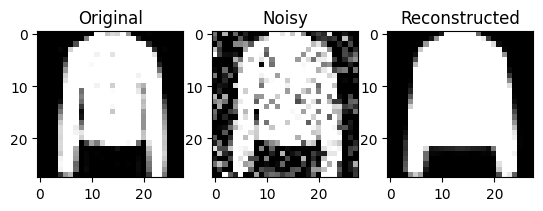

In [10]:
image_index = 10
visualization(x_test[image_index], x_test_noisy[image_index], predictions[image_index])

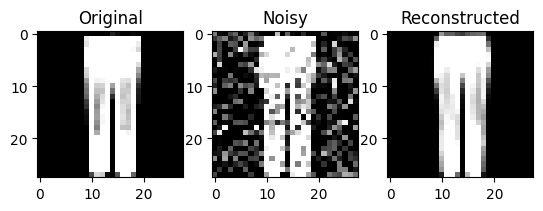

In [11]:
image_index = 15
visualization(x_test[image_index], x_test_noisy[image_index], predictions[image_index])

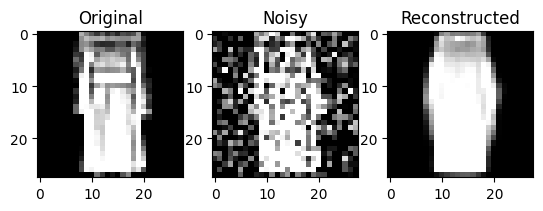

In [12]:
image_index = 2222
visualization(x_test[image_index], x_test_noisy[image_index], predictions[image_index])

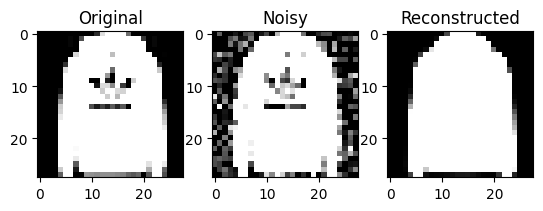

In [13]:
image_index = 367
visualization(x_test[image_index], x_test_noisy[image_index], predictions[image_index])

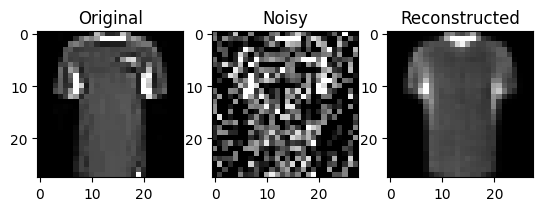

In [14]:
image_index = 5555
visualization(x_test[image_index], x_test_noisy[image_index], predictions[image_index])